In [1]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, json, re
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from collections import Counter

## Dataset: Book Summaries

In [2]:
# loading only title and summary column, rest is unnecessary
book_df = pd.read_csv('booksummaries.txt', sep = '\t', usecols = [2,3,5,6], header = None , names = ['Title','Author','Genres','Summary'])
book_df.dropna(inplace = True)
book_df.reset_index(drop = True, inplace = True)

book_df.head()

,Title,Author,Genres,Summary
0,Animal Farm,George Orwell,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,A Fire Upon the Deep,Vernor Vinge,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
4,All Quiet on the Western Front,Erich Maria Remarque,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge..."


### Data preparation
1. Remove punctuation from text.  
2. Convert Genres column from json string to list

In [3]:
import string
sep = chr(0)
trans = str.maketrans('','',string.punctuation)
book_df['summary'] = sep.join(book_df['Summary']).translate(trans).lower().split(sep)

book_df['Genres'] = book_df['Genres'].apply(lambda s: list(json.loads(s).values()))

book_df.head()

,Title,Author,Genres,Summary,summary
0,Animal Farm,George Orwell,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca...",old major the old boar on the manor farm call...
1,A Clockwork Orange,Anthony Burgess,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan...",alex a teenager living in nearfuture england ...
2,The Plague,Albert Camus,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...,the text of the plague is divided into five p...
3,A Fire Upon the Deep,Vernor Vinge,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...,the novel posits that space around the milky ...
4,All Quiet on the Western Front,Erich Maria Remarque,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge...",the book tells the story of paul bäumer a ger...


### I will be using two vectorizers
First counts stop words and second doesn't.

In [4]:
vect_w = CountVectorizer(stop_words = None, token_pattern = r'(?u)\b\w+\b')
CM_w = vect_w.fit_transform(book_df['summary'].values) # Count Matrix with stopwords
print(CM_w.shape)

(12055, 128677)


In [5]:
lotr_ind = book_df.loc[ book_df.Title == 'The Lord of the Rings' ].index[0]
print("LotR genres:")
print(book_df.iloc[lotr_ind]['Genres'])

LotR genres:
['Adventure novel', 'Speculative fiction', 'Fantasy', 'Fiction', 'Chivalric romance', 'High fantasy']


In [6]:


lotr_vec = CM_w[lotr_ind]
dist = pairwise_distances(lotr_vec, CM_w)
book_df['eucl_w'] = dist[0]
book_df[['Title','Author','Genres','eucl_w']].sort_values(by = 'eucl_w').head(10)


,Title,Author,Genres,eucl_w
51,The Lord of the Rings,J. R. R. Tolkien,"[Adventure novel, Speculative fiction, Fantasy...",0.000000
11410,The Fellowship of the Ring,J. R. R. Tolkien,"[Fantasy, Autobiography, Biography, Reference,...",63.379808
196,The Return of the King,J. R. R. Tolkien,"[Science Fiction, Biography, Speculative ficti...",63.560994
195,The Two Towers,J. R. R. Tolkien,"[Science Fiction, Children's literature, Fanta...",78.243211
11818,Berge Meere und Giganten,Alfred Döblin,[Science Fiction],80.280757
6077,Heirs of Empire,David Weber,"[Space opera, Speculative fiction, Novel, Mili...",83.060219
2099,The High King,Lloyd Alexander,"[Children's literature, Fantasy, Speculative f...",83.988094
2051,Deadhouse Gates,Steven Erikson,"[Speculative fiction, Fantasy, Fiction]",84.350459
1345,The Sword of Shannara,Terry Brooks,"[Science Fiction, Children's literature, Specu...",86.417591
6283,Deep Six,Clive Cussler,"[Children's literature, Fiction, Adventure nov...",86.723699


### Top 3 of our closest book are from the same author and same series.
First after that is 'Berge Meere und Giganten' which is completely unrelated as it's story revolves around future human society and it's conflicts, but it's also closest.  
And second is 'Heirs of Empire' which story is based on more futuristic setting.  
Let's check which words are msot common between them.

In [7]:
def top_words(title):
  s = book_df.loc[book_df.Title == title].summary.iloc[0]
  df = pd.DataFrame.from_dict(Counter(s.lower().split()),orient = 'index',columns=['count'])
  return df.sort_values(by='count', ascending=False)

In [8]:
common_words = top_words('The Lord of the Rings').join(top_words('Berge Meere und Giganten'),how='inner',lsuffix="_LotR",rsuffix = "_Berge")
common_words.sort_values(by = 'count_Berge', ascending = False)

,count_LotR,count_Berge
the,133,135
and,73,69
of,67,63
to,44,48
a,15,29
...,...,...
such,1,1
southern,1,1
no,1,1
driven,1,1


In [9]:
common_words = top_words('The Lord of the Rings').join(top_words('Heirs of Empire'),how='inner',lsuffix="_LotR",rsuffix = "_Heir")
common_words.sort_values(by = 'count_Heir', ascending = False)

,count_LotR,count_Heir
the,133,132
and,73,64
to,44,55
of,67,50
a,15,32
...,...,...
chief,1,1
most,1,1
force,1,1
arrive,1,1


This words don't really have real meaning when searching for related books based on story.  
We can try to change it using TF-IDF.

In [10]:
vect_w = CountVectorizer(stop_words = None, token_pattern = r'(?u)\b\w+\b')
tfidf = TfidfTransformer(smooth_idf = False, norm = None)
CM_w = vect_w.fit_transform(book_df['summary'].values)
TFM = tfidf.fit_transform(CM_w)
print(TFM.shape)

(12055, 128677)


In [11]:
dist = pairwise_distances(TFM[lotr_ind],TFM)
book_df['tfidf_eucl'] = dist[0]
book_df[['Title','Author','Genres','tfidf_eucl']].sort_values(by = 'tfidf_eucl').head(10)

,Title,Author,Genres,tfidf_eucl
51,The Lord of the Rings,J. R. R. Tolkien,"[Adventure novel, Speculative fiction, Fantasy...",0.000000
11410,The Fellowship of the Ring,J. R. R. Tolkien,"[Fantasy, Autobiography, Biography, Reference,...",271.229490
196,The Return of the King,J. R. R. Tolkien,"[Science Fiction, Biography, Speculative ficti...",280.138202
195,The Two Towers,J. R. R. Tolkien,"[Science Fiction, Children's literature, Fanta...",280.392500
9290,The Last Ringbearer,Kirill Yeskov,"[Parallel novel, Dark fantasy, High fantasy]",418.605522
58,The Hobbit,J. R. R. Tolkien,"[Children's literature, Juvenile fantasy, Adve...",423.091257
6625,Expecting Someone Taller,Tom Holt,"[Satire, Fantasy, Speculative fiction, Comedy]",429.276790
6542,The Road,Cormac McCarthy,"[Literary fiction, Science Fiction, Apocalypti...",430.881222
1684,The Smoke Ring,Larry Niven,"[Science Fiction, Speculative fiction, Fiction...",431.748140
4964,The House on the Borderland,William Hope Hodgson,"[Fantasy, Science Fiction, Speculative fiction...",432.656769


### Already much better 'The Last Ringbearer' is unofficial sequel to Lord of the rings series and 'The Hobbit' not only is from same author but it also is prequel of Lords of the rings.
### But 'Expecting Someone Taller' isn't really that similiar.
#### So let's check how tfidf assigned word weights.

In [12]:
tokenizer = re.compile(r"(?u)\b\w+\b").findall

def top_words_tf_idf(title):
  row = book_df.loc[ book_df.Title == title ]
  row_ind = row.index[0]
  #words = row.summary.iloc[0].lower().split()
  words = tokenizer(row.summary.iloc[0].lower())
  
  df = pd.DataFrame.from_dict({ w: TFM[row_ind,vect_w.vocabulary_[w]] for w in words },orient='index', columns=['tf-idf'])
  return df.sort_values(by = 'tf-idf', ascending = False)

In [13]:
top_words_tf_idf('The Lord of the Rings').join(top_words_tf_idf('Expecting Someone Taller'), how = 'inner', lsuffix = "_LotR", rsuffix = "_Taller").head(15)
# top_words_tf_idf('Expecting Someone Taller')

,tf-idf_LotR,tf-idf_Taller
the,134.241446,32.298694
ring,109.372538,47.553277
and,75.695444,15.553858
of,69.681832,13.520355
to,46.277080,12.621022
his,34.086971,3.787441
by,32.384272,2.590742
from,21.825745,1.364109
in,21.532121,4.306424
him,20.997845,4.845656


### We see that the only meaningful word in this list is 'ring'.
### That explains why 'Expecting Someone Taller' is that close to 'The Lord of the Rings'
### Now let's compare length of their summaries.  

In [14]:
print(len(tokenizer(book_df[book_df.Title == 'The Lord of the Rings'].summary.values[0])))
print(len(tokenizer(book_df[book_df.Title == 'Expecting Someone Taller'].summary.values[0])))

1509
364


### Okay so summary of 'Expecting Someone Taller' is much shorter.  
### We should calculate length for every summary and plot so we could see which lengths are most common.  

In [15]:
book_df['length'] = book_df['summary'].apply(lambda x: len(tokenizer(x)))
top_100 = book_df.sort_values(by='tfidf_eucl').head(100).length.values
# book_df[['Title','length','tfidf_eucl']].sort_values(by='tfidf_eucl').head(10)

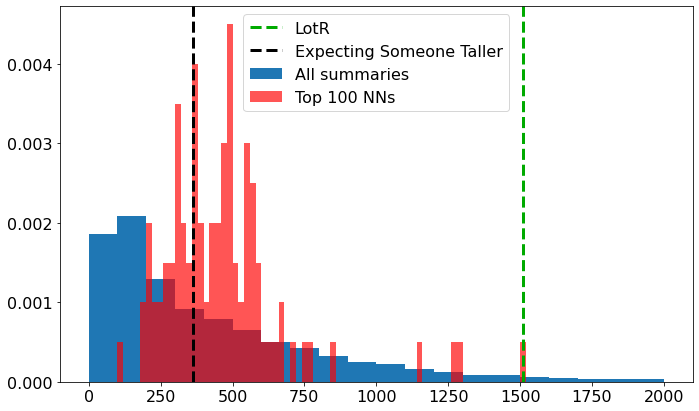

In [16]:
plt.rcParams['font.size'] = 16
plt.figure(figsize = (10,6))


taller_ind = book_df[book_df.Title == 'Expecting Someone Taller'].index[0]
plt.hist(book_df.length.values, range = (0,2000), bins = 20, density = True, label = "All summaries")
plt.hist(top_100, range = (0,2000), bins = 100, density = True, color = '#F00A', label = "Top 100 NNs")

plt.axvline(book_df.iloc[lotr_ind].length, ls = '--', lw = 3, c = '#0A0',label = 'LotR')
plt.axvline(book_df.iloc[taller_ind].length, ls = '--', lw = 3, c = '#000', label = 'Expecting Someone Taller')

plt.legend()
plt.tight_layout()
plt.show()


### From plot we see that most summaries are under 500 words when Lord of the rings has 1509. And beacuse we are using euclidean distance we are favoring shorter summaries. We could try to solve it with cosine distance.

In [17]:
dist = cosine_distances(TFM[lotr_ind],TFM)
book_df['tfidf_cos'] = dist[0]
book_df[['Title','Author','Genres','tfidf_cos']].sort_values(by='tfidf_cos').head(10)

,Title,Author,Genres,tfidf_cos
51,The Lord of the Rings,J. R. R. Tolkien,"[Adventure novel, Speculative fiction, Fantasy...",3.330669e-16
11410,The Fellowship of the Ring,J. R. R. Tolkien,"[Fantasy, Autobiography, Biography, Reference,...",1.924952e-01
195,The Two Towers,J. R. R. Tolkien,"[Science Fiction, Children's literature, Fanta...",2.219389e-01
196,The Return of the King,J. R. R. Tolkien,"[Science Fiction, Biography, Speculative ficti...",2.221031e-01
9290,The Last Ringbearer,Kirill Yeskov,"[Parallel novel, Dark fantasy, High fantasy]",6.332633e-01
58,The Hobbit,J. R. R. Tolkien,"[Children's literature, Juvenile fantasy, Adve...",6.689009e-01
1265,The Wealth of Nations,Adam Smith,[Non-fiction],7.071267e-01
1938,Ghostwritten,David Mitchell,[Novel],7.094645e-01
7105,The Ballad of the White Horse,G. K. Chesterton,[Poetry],7.131354e-01
5956,"The Boats of the ""Glen Carrig""",William Hope Hodgson,"[Fantasy, Speculative fiction, Horror, Fiction]",7.160547e-01


### We see that cosine distance helped somewhat. We no longer have 'Expecting Someone Taller' as it's only a short novel, instead we have 'The Wealth of Nations' which isn't good either as belongs to 'non fictional' genre.

In [18]:
top_100c = book_df.sort_values(by='tfidf_cos').head(100).length.values

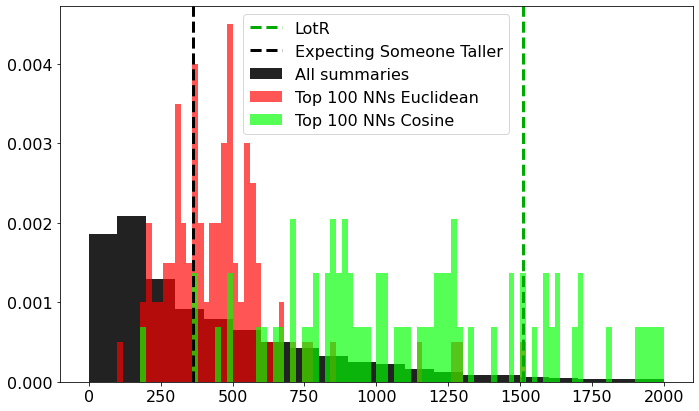

In [19]:
plt.rcParams['font.size'] = 16
plt.figure(figsize = (10,6))


taller_ind = book_df[book_df.Title == 'Expecting Someone Taller'].index[0]
plt.hist(book_df.length.values, range = (0,2000), bins = 20, color = "#222", density = True, label = "All summaries")
plt.hist(top_100, range = (0,2000), bins = 100, density = True, color = '#F00A', label = "Top 100 NNs Euclidean")
plt.hist(top_100c, range = (0,2000), bins = 100, density = True, color = '#0F0A', label = "Top 100 NNs Cosine")

plt.axvline(book_df.iloc[lotr_ind].length, ls = '--', lw = 3, c = '#0A0',label = 'LotR')
plt.axvline(book_df.iloc[taller_ind].length, ls = '--', lw = 3, c = '#000', label = 'Expecting Someone Taller')

plt.legend()
plt.tight_layout()
plt.show()


### Looks better as it includes all lengths, but still we don't get good results.
### Now let's compare how we will do if we remove stop words from the start. I will still be using tf-idf beacuse not all common words need to be stop words.

In [20]:
vect_wo = CountVectorizer(stop_words = 'english', token_pattern = r"(?u)\b\w+\b")
CM_wo = vect_wo.fit_transform(book_df['summary'].values)
tfidf_wo = TfidfTransformer(norm = None, smooth_idf = False)
TFM_wo = tfidf_wo.fit_transform(CM_wo)

In [21]:
dist = pairwise_distances(TFM_wo[lotr_ind],TFM_wo)
distc = cosine_distances(TFM_wo[lotr_ind],TFM_wo)

book_df['tfidf_wo_eucl'] = dist[0]
book_df['tfidf_wo_cos'] = distc[0]

book_df[['Title','Author','Genres','tfidf_wo_eucl']].sort_values(by = 'tfidf_wo_eucl').head(10)

,Title,Author,Genres,tfidf_wo_eucl
51,The Lord of the Rings,J. R. R. Tolkien,"[Adventure novel, Speculative fiction, Fantasy...",0.000000
11410,The Fellowship of the Ring,J. R. R. Tolkien,"[Fantasy, Autobiography, Biography, Reference,...",261.332767
195,The Two Towers,J. R. R. Tolkien,"[Science Fiction, Children's literature, Fanta...",268.474645
196,The Return of the King,J. R. R. Tolkien,"[Science Fiction, Biography, Speculative ficti...",271.745645
4212,The Short Reign of Pippin IV,John Steinbeck,[Speculative fiction],395.789257
9916,Gollum: How We Made Movie Magic,Andy Serkis,[Memoir],396.771027
7310,A Theft,Saul Bellow,[Novel],397.893971
10275,Swallowing Darkness,Laurell K. Hamilton,"[Fantasy, Horror]",397.970760
10893,Divine Misdemeanors,Laurell K. Hamilton,"[Fantasy, Horror]",398.016458
2654,The Clue of the Hissing Serpent,Franklin W. Dixon,"[Mystery, Detective fiction, Fiction]",398.435734


### When using euclidean distances with exlucion of stop words we get really similiar result.
### And what's interesting we see book 'Gollum: How We Made Movie Magic' which is about how animators, animated Gollum - a character in 'Lord of the Rings' movie adaptation.

In [22]:
book_df[['Title','Author','Genres','tfidf_wo_cos']].sort_values(by = 'tfidf_wo_cos').head(10)

,Title,Author,Genres,tfidf_wo_cos
51,The Lord of the Rings,J. R. R. Tolkien,"[Adventure novel, Speculative fiction, Fantasy...",1.887379e-15
11410,The Fellowship of the Ring,J. R. R. Tolkien,"[Fantasy, Autobiography, Biography, Reference,...",2.192772e-01
195,The Two Towers,J. R. R. Tolkien,"[Science Fiction, Children's literature, Fanta...",2.549543e-01
196,The Return of the King,J. R. R. Tolkien,"[Science Fiction, Biography, Speculative ficti...",2.676523e-01
9290,The Last Ringbearer,Kirill Yeskov,"[Parallel novel, Dark fantasy, High fantasy]",7.710682e-01
58,The Hobbit,J. R. R. Tolkien,"[Children's literature, Juvenile fantasy, Adve...",7.858946e-01
6625,Expecting Someone Taller,Tom Holt,"[Satire, Fantasy, Speculative fiction, Comedy]",8.648343e-01
4212,The Short Reign of Pippin IV,John Steinbeck,[Speculative fiction],8.732924e-01
6750,My Side of the Mountain,Jean Craighead George,"[Children's literature, Young adult literature]",8.754676e-01
5698,Seduced by Moonlight,Laurell K. Hamilton,"[Fantasy, Speculative fiction, Horror, Fiction...",8.851868e-01


### And when using cosine distances wwwith exclution of stop words we see best results:
### First we have all books from same series then we have sequel followed by prequel. Unfortunately rest isn't as good, even genres are different.
### But let's check why 'The Short Reign of Pippin IV' is this close, as it's story is about french astronomer.

In [23]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def top_words_tfidf_wo(title):
  row = book_df.loc[ book_df.Title == title ]
  row_ind = row.index[0]
  words = tokenizer(row.summary.iloc[0].lower())
  df = pd.DataFrame.from_dict({ w: TFM_wo[row_ind,vect_wo.vocabulary_[w]] for w in words if w not in ENGLISH_STOP_WORDS },orient='index', columns=['tf-idf'])
  return df.sort_values(by = 'tf-idf', ascending = False)

In [24]:
top_words_tfidf_wo('The Lord of the Rings').join(top_words_tfidf_wo('The Short Reign of Pippin IV'),how = 'inner', lsuffix='_LotR',rsuffix='_Pippin')

,tf-idf_LotR,tf-idf_Pippin
pippin,84.513246,33.805299
king,6.914025,10.371037
rebellion,5.114031,5.114031
novel,4.495266,2.247633
suddenly,3.813826,3.813826
eventually,2.484080,2.484080


### In this case word 'pippin' has highest weight. And that good beacuse Pippin is one of the main character from Lord of the Rings.
### But in this case it's detrimental beacuse it's just coincidence that characters have same name.

## Final conclusion
Using this method to find similiar books isn't the best, as we only get books that summaries contain same words and as we could see, we can get completely different book just beacuse both of them contain one rare word.
